In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import copy
from utils import merge_image_superpixels
from scipy.spatial import Delaunay
import networkx as nx
from networkx.algorithms.shortest_paths.weighted import dijkstra_path

In [2]:
image_names = ["2007_000068", "2007_000121", "2007_000123"]
voc_ext = ".jpg"
gt_ext = ".png"

voc_dir = "data/voc12/"
gt_dir = "data/gt/"

images = []
gt_images = []

images_gray = []

for name in image_names:
    img = cv2.imread(voc_dir + name + voc_ext)
    gt = cv2.imread(gt_dir + name + gt_ext)
   
    images.append(img)
    gt_images.append(gt)

    images_gray.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

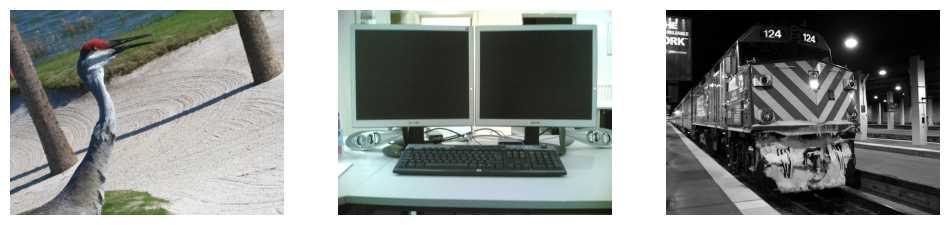

In [3]:
fig = plt.figure(figsize=(12, 4))

rows = 1
cols = 3

for i, img in enumerate(images):
    fig.add_subplot(rows, cols, i+1)
    plt.axis("off")
    plt.imshow(img[:,:,::-1])

## Superpixels

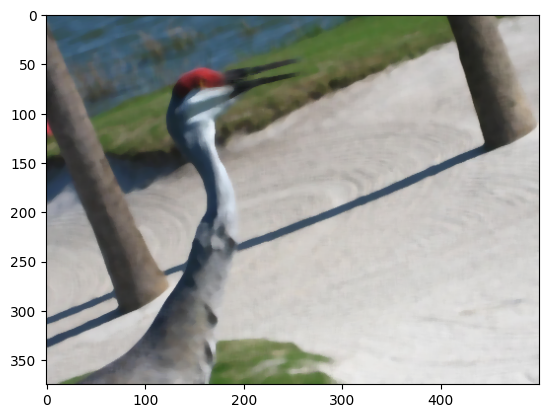

In [4]:
median_blurred = cv2.medianBlur(images[0], 7)
plt.imshow(median_blurred[:,:,::-1])

In [5]:
use_blurred = True
lab_img = cv2.cvtColor(images[0], cv2.COLOR_BGR2Lab)

if use_blurred:
    lab_img = cv2.cvtColor(median_blurred, cv2.COLOR_BGR2Lab)

superpixels_slic = cv2.ximgproc.createSuperpixelSLIC(lab_img, algorithm=cv2.ximgproc.SLIC, region_size=16)
superpixels_slic.iterate(20)
superpixels_slic_mask = superpixels_slic.getLabelContourMask()
print(superpixels_slic.getNumberOfSuperpixels())

height, width, channels = lab_img.shape[0], lab_img.shape[1], lab_img.shape[2]

superpixels_seeds = cv2.ximgproc.createSuperpixelSEEDS(width, height, channels, 1000, 20)
superpixels_seeds.iterate(lab_img, 20)
superpixels_seeds_mask = superpixels_seeds.getLabelContourMask()
print(superpixels_seeds.getNumberOfSuperpixels())

superpixels_lsc = cv2.ximgproc.createSuperpixelLSC(lab_img, region_size=16)
superpixels_lsc.iterate(20)
superpixels_lsc_mask = superpixels_lsc.getLabelContourMask()
print(superpixels_lsc.getNumberOfSuperpixels())

713
713
713


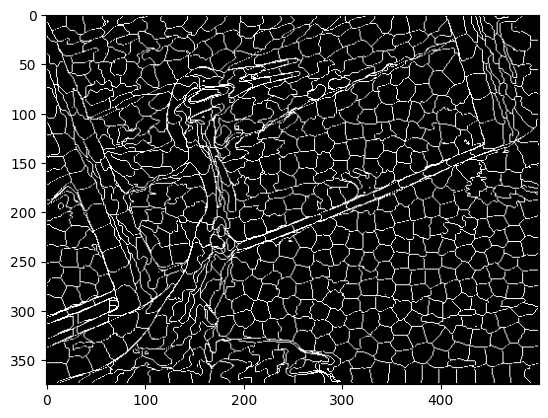

In [6]:
plt.imshow(superpixels_slic_mask, cmap="gray")

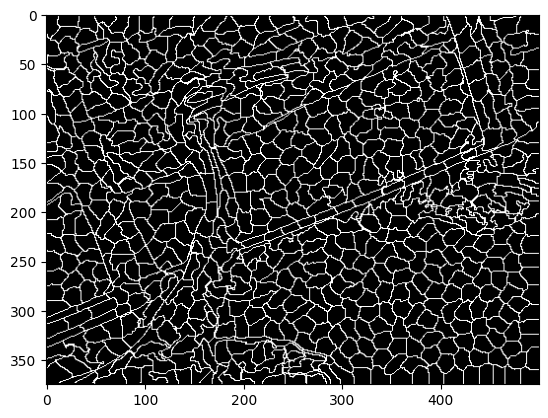

In [7]:
plt.imshow(superpixels_seeds_mask, cmap="gray")

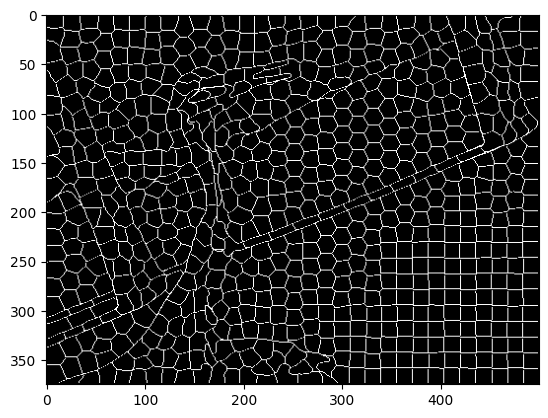

In [8]:
plt.imshow(superpixels_lsc_mask, cmap="gray")

In [9]:
chosen_superpixels = superpixels_lsc
chosen_superpixels_mask = superpixels_lsc_mask
superpixel_contour_img = merge_image_superpixels(images[0], chosen_superpixels_mask, [0,255,0])

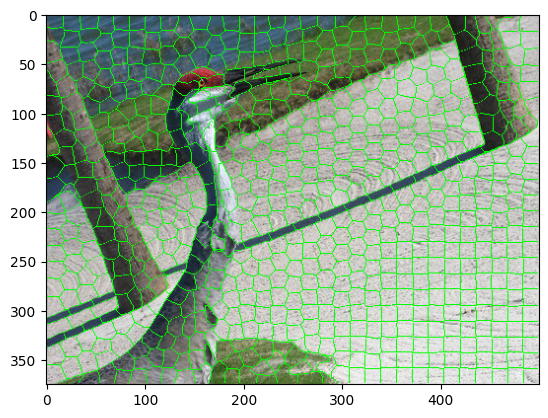

In [10]:
plt.imshow(superpixel_contour_img[:,:,::-1])

In [11]:
superpixel_labels = chosen_superpixels.getLabels()
masks = []

for i in np.unique(superpixel_labels):
    mask = np.where(superpixel_labels == i, 1, 0).astype(np.uint8)
    masks.append(mask)

dist_trans = cv2.distanceTransform(~chosen_superpixels_mask, cv2.DIST_L2, 5)

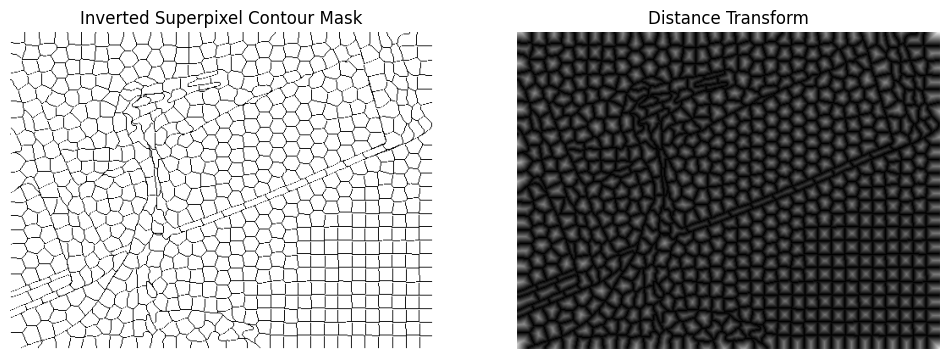

In [12]:
fig = plt.figure(figsize=(12, 6))

rows = 1
cols = 2

fig.add_subplot(rows, cols, 1)
plt.axis("off")
plt.title("Inverted Superpixel Contour Mask")
plt.imshow(~chosen_superpixels_mask, cmap="gray")

fig.add_subplot(rows, cols, 2)
plt.axis("off")
plt.title("Distance Transform")
plt.imshow(dist_trans, cmap="gray")

In [13]:
dist_trans.shape

(375, 500)

In [14]:
local_maxima_coord = []

for mask in masks:
    masked = mask * dist_trans
    local_maximum = np.argwhere(masked == np.max(masked))[0]
    dist_trans[local_maximum[0], local_maximum[1]] = 1
    
    local_maxima_coord.append(np.array([local_maximum[1], (dist_trans.shape[0]-1)-local_maximum[0]]))

local_maxima_coord = np.array(local_maxima_coord)

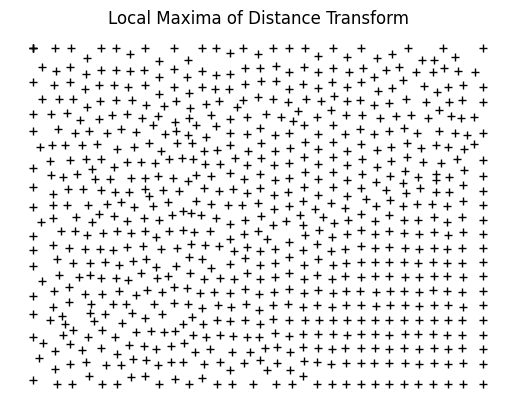

In [15]:
plt.axis("off")
plt.title("Local Maxima of Distance Transform")
plt.plot(local_maxima_coord[:,0], local_maxima_coord[:,1], '+', color='black')

In [16]:
trangulation = Delaunay(local_maxima_coord)
len(trangulation.simplices)

1348

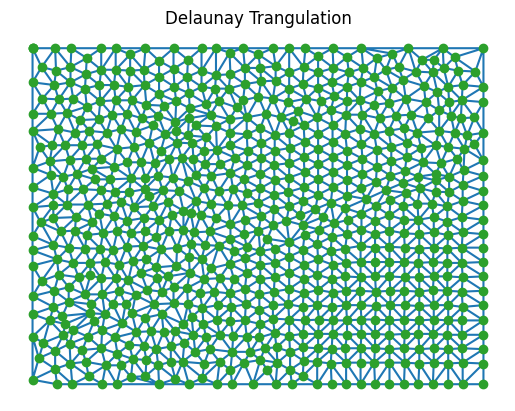

In [17]:
plt.triplot(local_maxima_coord[:,0], local_maxima_coord[:,1], trangulation.simplices)
plt.plot(local_maxima_coord[:,0], local_maxima_coord[:,1], 'o')
plt.axis("off")
plt.title("Delaunay Triangulation")
plt.show()

In [18]:
G = nx.Graph()
for path in trangulation.simplices:
    nx.add_path(G, path)

## Semi-supervised mask creation

In [19]:
clicks = []

def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        x_math = x
        y_math = dist_trans.shape[0]-y
        print(f"Left button clicked at ({x_math}, {y_math})")
        clicks.append(np.array([x_math, y_math]))

In [20]:
clicks = []

cv2.imshow("Image", superpixel_contour_img)
cv2.setMouseCallback('Image', mouse_callback)
cv2.waitKey(0)
cv2.destroyAllWindows()

Left button clicked at (45, 6)
Left button clicked at (111, 101)
Left button clicked at (141, 184)
Left button clicked at (112, 261)
Left button clicked at (124, 317)
Left button clicked at (189, 336)
Left button clicked at (271, 340)
Left button clicked at (320, 316)
Left button clicked at (256, 285)
Left button clicked at (203, 261)
Left button clicked at (208, 155)
Left button clicked at (192, 68)
Left button clicked at (181, 12)


In [21]:
distances = []
nearest_to_clicks = []

for i, point_click in enumerate(clicks):
    for j, point_maximum in enumerate(local_maxima_coord):
        distances.append(np.array([
            i, j, cv2.norm(point_maximum, point_click)
        ]))

distances = np.array(distances)

for i in range(len(clicks)):
    interest_points = distances[distances[:,0] == i]
    minimum_dist = interest_points[interest_points[:,2] == np.min(interest_points[:,2]), 1]
    nearest_to_clicks.append(int(minimum_dist[0]))

indices_of_nearest = []

for coord_click in  local_maxima_coord[nearest_to_clicks]:
    for i, coord in enumerate(local_maxima_coord):
        if (coord == coord_click).all():
            indices_of_nearest.append(i)
            break

indices_of_nearest = np.array(indices_of_nearest)

In [22]:
result = copy.deepcopy(local_maxima_coord[nearest_to_clicks])

for i in range(len(indices_of_nearest)-1):
    path = dijkstra_path(G, indices_of_nearest[i], indices_of_nearest[i+1])
    result = np.append(result, values=local_maxima_coord[path][1:-1], axis=0)

path = dijkstra_path(G, indices_of_nearest[0], indices_of_nearest[-1])
result = np.append(result, values=local_maxima_coord[path][1:-1], axis=0)

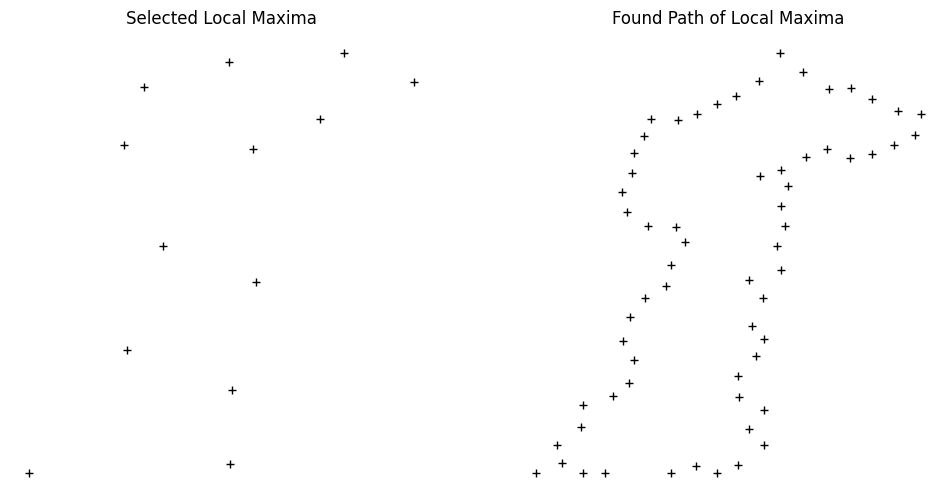

In [23]:
fig = plt.figure(figsize=(12, 6))

rows = 1
cols = 2

fig.add_subplot(rows, cols, 1)
plt.axis("off")
plt.title("Selected Local Maxima")
plt.plot(
    local_maxima_coord[nearest_to_clicks][:,0],
    local_maxima_coord[nearest_to_clicks][:,1],
    '+', color='black'
)

fig.add_subplot(rows, cols, 2)
plt.axis("off")
plt.title("Found Path of Local Maxima")
plt.plot(result[:,0], result[:,1], '+', color='black')

Draw masks at local maxima:

In [24]:
selected_superpixels = np.zeros(dist_trans.shape, np.uint8)

for mask in masks:
    for local_max in result:
        if mask[(dist_trans.shape[0]-1)-local_max[1], local_max[0]] == 1:
            selected_superpixels |= mask

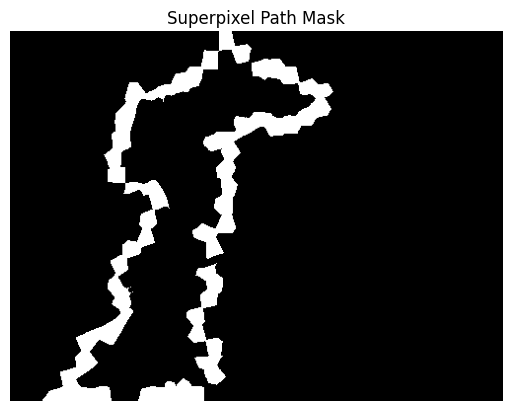

In [25]:
plt.axis("off")
plt.title("Superpixel Path Mask")
plt.imshow(selected_superpixels, cmap="gray")

In [26]:
struct_elem = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
dilated_selection = cv2.dilate(selected_superpixels, struct_elem, iterations=3)

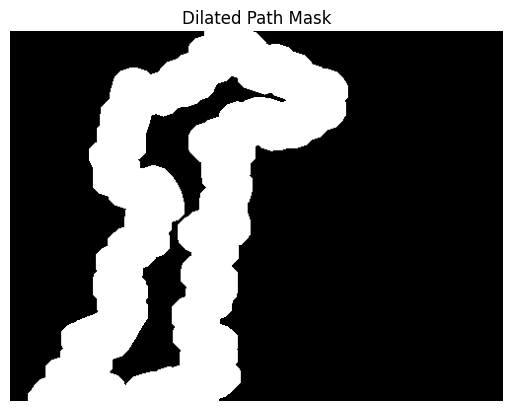

In [27]:
plt.axis("off")
plt.title("Dilated Path Mask")
plt.imshow(dilated_selection, cmap="gray")

In [28]:
contours, _ = cv2.findContours(dilated_selection, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask = np.zeros(dilated_selection.shape, dtype=np.uint8)
mask = cv2.fillPoly(mask, contours, 1)

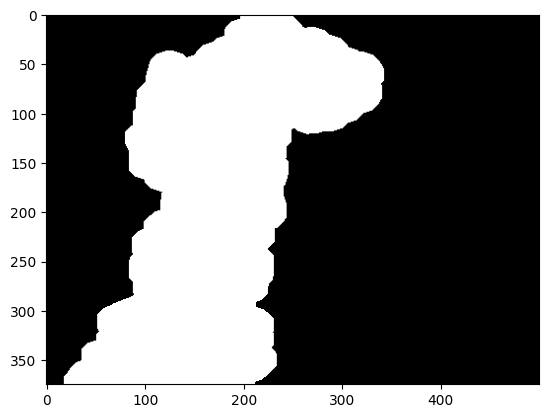

In [29]:
plt.imshow(mask, cmap="gray")

In [30]:
dilated_selection[dilated_selection == 1] = cv2.GC_PR_FGD

certain_fg = np.logical_xor(mask, dilated_selection)
certain_fg[certain_fg == 1] = cv2.GC_FGD

grabcut_mask = dilated_selection + certain_fg

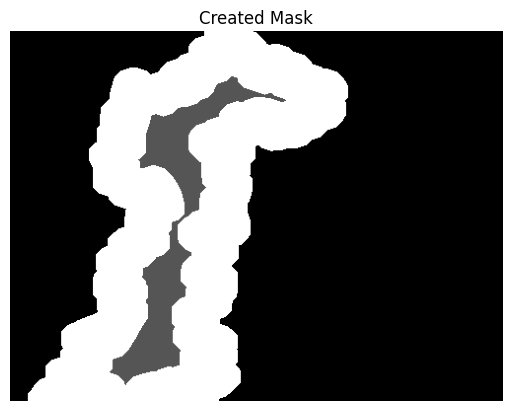

In [31]:
plt.axis("off")
plt.title("Created Mask")
plt.imshow(grabcut_mask, cmap="gray")

In [32]:
bgd_model = np.zeros((1,65),np.float64)
fgd_model = np.zeros((1,65),np.float64)
grabcut_mask, bgd_model, fgd_model = cv2.grabCut(images[0], grabcut_mask, None, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_MASK)

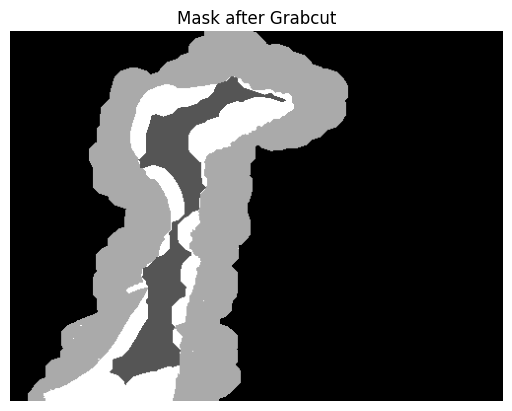

In [33]:
plt.axis("off")
plt.title("Mask after Grabcut")
plt.imshow(grabcut_mask, cmap="gray")

In [34]:
grabcut_mask = np.where((grabcut_mask == cv2.GC_FGD) | (grabcut_mask == cv2.GC_PR_FGD), 1, 0)
image_gt_gray = cv2.cvtColor(gt_images[0], cv2.COLOR_BGR2GRAY)
image_gt_gray = np.where(image_gt_gray > 0, 1, 0)

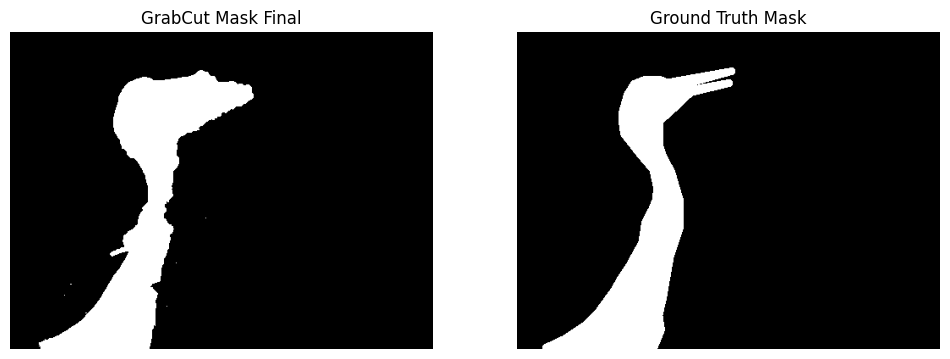

In [35]:
fig = plt.figure(figsize=(12, 6))

rows = 1
cols = 2

fig.add_subplot(rows, cols, 1)
plt.axis("off")
plt.title("GrabCut Mask Final")
plt.imshow(grabcut_mask, cmap="gray")

fig.add_subplot(rows, cols, 2)
plt.axis("off")
plt.title("Ground Truth Mask")
plt.imshow(image_gt_gray, cmap="gray")

In [36]:
segmented = images[0] * cv2.merge([grabcut_mask,grabcut_mask,grabcut_mask])

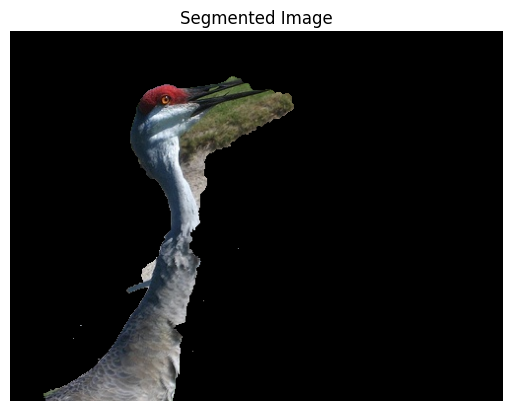

In [37]:
plt.axis("off")
plt.title("Segmented Image")
plt.imshow(segmented[:,:,::-1])